# Imports

In [58]:
# !conda list

In [59]:
import pandas
import os
import itertools
import random
import cv2
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
import copy
import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder

# Part 1

## Part 1.1

In [60]:
from styles import styles, styles_count

In [61]:
styles

{'прическа': ['нет волос',
  'длинные в пучок',
  'длинные волнистые',
  'длинные прямые',
  'короткая волнистые',
  'короткая прямые',
  'короткая курчавые'],
 'цвет волос': ['черный',
  'блонд',
  'каштановый',
  'пастельный розовый',
  'рыжий',
  'серебристо серый'],
 'аксесуар': ['нет очков', 'круглые очки', 'солнцезащитные очки'],
 'одежда': ['худи',
  'комбинезон',
  'футболка с круглым вырезом',
  'футболка с V-вырезом'],
 'цвет одежды': ['черный',
  'синий',
  'серый',
  'зеленый',
  'оранжевый',
  'розовый',
  'красный',
  'белый']}

In [62]:
styles_count

{'прическа': [7, 0, 1, 23, 1, 11, 7],
 'цвет волос': [7, 6, 2, 3, 8, 24],
 'аксесуар': [11, 22, 17],
 'одежда': [7, 18, 19, 6],
 'цвет одежды': [4, 5, 6, 8, 6, 8, 7, 6]}

In [63]:
def get_random_style(styles, styles_count):
    all_combs = []
    features_and_probs = copy.deepcopy(styles)
    for x in styles:
        for y in range(len(styles[x])):
            features_and_probs[x][y] = [
                styles[x][y],
                (styles_count[x][y] + 1)
                / (sum(styles_count[x]) + len(styles_count[x])),
            ]
    all_combs = list(itertools.product(*features_and_probs.values()))
    styles_and_prob = []
    for x in all_combs:
        pr = 1
        for _ in x:
            pr *= _[1]
        style_and_prob = {"style": [_[0] for _ in x], "prob": pr}
        styles_and_prob.append(style_and_prob)
    probs = [x["prob"] for x in styles_and_prob]
    return random.choices(styles_and_prob, probs)

Функция выше подсчитывает вероятности каждого элемента в стиле на основе входных styles и их количества, а также выдает случайный стиль

In [64]:
def get_all_probs(styles, styles_count):
    features_and_probs = copy.deepcopy(styles)
    for x in styles:
        for y in range(len(styles[x])):
            features_and_probs[x][y] = [
                styles[x][y],
                (styles_count[x][y] + 1)
                / (sum(styles_count[x]) + len(styles_count[x])),
            ]
    all_combs = list(itertools.product(*features_and_probs.values()))
    styles_and_prob = []
    for x in all_combs:
        pr = 1
        for _ in x:
            pr *= _[1]
        style_and_prob = {"style": [_[0] for _ in x], "prob": pr}
        styles_and_prob.append(style_and_prob)
    return styles_and_prob

Функция выше подсчитывает вероятности каждого элемента в стиле на основе входных styles и их количества, а также выдает все стили и их вероятности

In [65]:
get_random_style(styles, styles_count)

[{'style': ['нет волос',
   'серебристо серый',
   'солнцезащитные очки',
   'футболка с круглым вырезом',
   'красный'],
  'prob': 0.0010870811815920191}]

In [66]:
get_all_probs(styles, styles_count)

[{'style': ['нет волос', 'черный', 'нет очков', 'худи', 'черный'],
  'prob': 5.797766301824104e-05},
 {'style': ['нет волос', 'черный', 'нет очков', 'худи', 'синий'],
  'prob': 6.957319562188924e-05},
 {'style': ['нет волос', 'черный', 'нет очков', 'худи', 'серый'],
  'prob': 8.116872822553745e-05},
 {'style': ['нет волос', 'черный', 'нет очков', 'худи', 'зеленый'],
  'prob': 0.00010435979343283386},
 {'style': ['нет волос', 'черный', 'нет очков', 'худи', 'оранжевый'],
  'prob': 8.116872822553745e-05},
 {'style': ['нет волос', 'черный', 'нет очков', 'худи', 'розовый'],
  'prob': 0.00010435979343283386},
 {'style': ['нет волос', 'черный', 'нет очков', 'худи', 'красный'],
  'prob': 9.276426082918565e-05},
 {'style': ['нет волос', 'черный', 'нет очков', 'худи', 'белый'],
  'prob': 8.116872822553745e-05},
 {'style': ['нет волос', 'черный', 'нет очков', 'комбинезон', 'черный'],
  'prob': 0.00013769694966832247},
 {'style': ['нет волос', 'черный', 'нет очков', 'комбинезон', 'синий'],
  'prob

## Part 1.2

In [69]:
avatars_dir = "../../2024_deep_gen_models/HW_1.Bias_gen_and_autoencoders/avatars"
images_names = os.listdir(avatars_dir)

In [70]:
def get_probs_of_pixels(directory):
    images_names = os.listdir(avatars_dir)
    image_np = cv2.cvtColor(
        cv2.imread(os.path.join(avatars_dir, images_names[1])),
        cv2.COLOR_RGB2BGR,
    )
    probs_of_ppx = np.empty(image_np.shape).tolist()
    for x in range(len(probs_of_ppx)):
        for y in range(len(probs_of_ppx[x])):
            probs_of_ppx[x][y] = {}
    for image_name in images_names:
        image_np = cv2.cvtColor(
            cv2.imread(os.path.join(avatars_dir, image_name)),
            cv2.COLOR_RGB2BGR,
        )
        for y in range(image_np.shape[0]):
            for x in range(image_np.shape[1]):
                px_color = ",".join(map(str, image_np[y][x].tolist()))
                if px_color in probs_of_ppx[y][x]:
                    probs_of_ppx[y][x][px_color] += 1
                else:
                    probs_of_ppx[y][x][px_color] = 1
    for x in range(len(probs_of_ppx)):
        for y in range(len(probs_of_ppx[x])):
            for px_color in probs_of_ppx[x][y].keys():
                # probs_of_ppx[x][y][px_color] += 1
                # if probs_of_ppx[x][y][px_color] == 0:
                #     probs_of_ppx[x][y][px_color] = 1
                probs_of_ppx[x][y][px_color] = probs_of_ppx[x][y][
                    px_color
                ] / len(images_names)
    return probs_of_ppx

Функция подсчитывает вероятности каждого возможного пикселя, исходя из заданных изображений  
Мной было решено не добавлять 1 для каждого пикселя, иначе будет сгенерирован шум

In [71]:
def get_random_style(probs_of_ppx=None):
    if probs_of_ppx is None:
        probs_of_ppx = get_probs_of_pixels(avatars_dir)
    new_avatar = np.empty([len(probs_of_ppx), len(probs_of_ppx[0]), 3])
    for x in range(len(probs_of_ppx)):
        for y in range(len(probs_of_ppx[x])):
            new_avatar[x][y] = list(
                map(
                    int,
                    random.choices(
                        list(probs_of_ppx[x][y].keys()),
                        probs_of_ppx[x][y].values(),
                    )[0].split(","),
                )
            )
    return np.array(new_avatar).astype(int)

Данная функция на основе вероятностей пикселей возваращает случайный стиль

In [72]:
probs_of_ppx = get_probs_of_pixels(avatars_dir)
get_random_style(probs_of_ppx=probs_of_ppx)

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]])

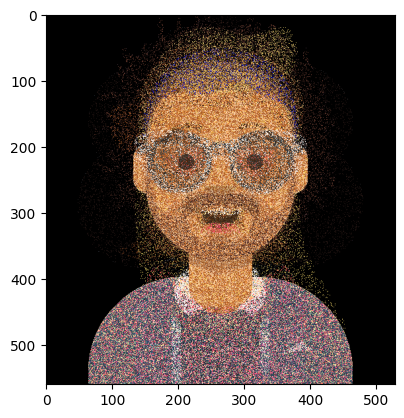

In [73]:
new_avatar1 = get_random_style(probs_of_ppx)
plt.imshow(new_avatar1)
plt.savefig(
    "./gen_avatars/avatar1.png"
)

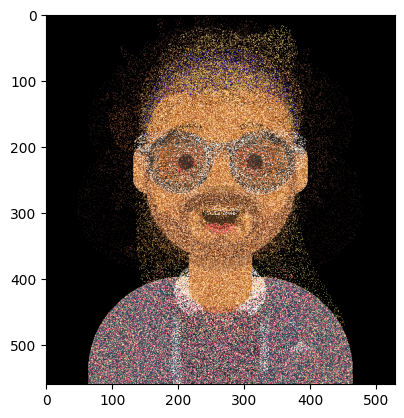

In [74]:
new_avatar2 = get_random_style(probs_of_ppx)
plt.imshow(new_avatar2)
plt.savefig(
    "./gen_avatars/avatar2.png"
)

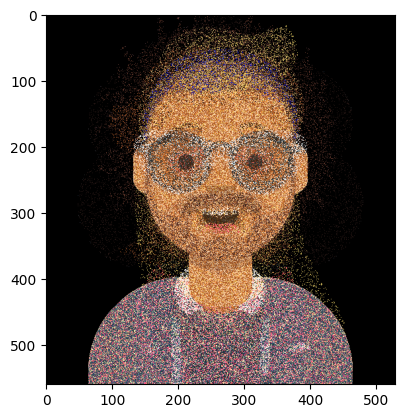

In [75]:
new_avatar3 = get_random_style(probs_of_ppx)
plt.imshow(new_avatar3)
plt.savefig(
    "./gen_avatars/avatar3.png"
)

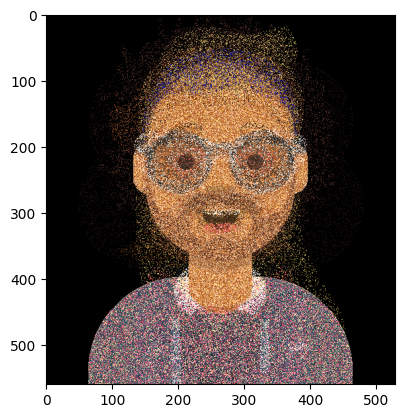

In [76]:
new_avatar4 = get_random_style(probs_of_ppx)
plt.imshow(new_avatar4)
plt.savefig(
    "./gen_avatars/avatar4.png"
)

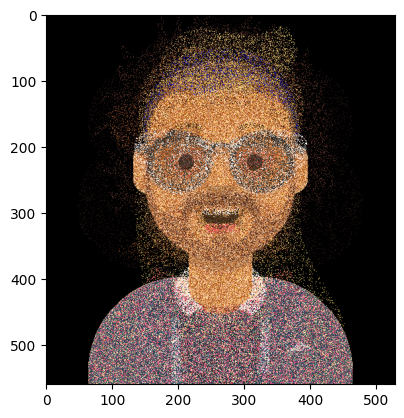

In [77]:
new_avatar5 = get_random_style(probs_of_ppx)
plt.imshow(new_avatar5)
plt.savefig(
    "./gen_avatars/avatar5.png"
)

In [78]:
(new_avatar4 == new_avatar4).sum() / (528 * 560 * 3)

1.0

In [79]:
(new_avatar4 == new_avatar5).sum() / (528 * 560 * 3)

0.5831123737373738

Ячейка выше демонстирует, что сгенерированные аватары отличаются друг от друга  
Очень похожи, потому что выборка маленькая, всего 11 аватаров

# Part 2

## Imports and vars

In [1]:
import os
import cv2
from PIL import Image
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import cv2
from torchvision.datasets import ImageFolder
from torch.utils.tensorboard import SummaryWriter
from matplotlib import pyplot as plt
from sklearn.metrics import f1_score, precision_score, recall_score

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
images_dir_train = "./dataset/train"
images_dir_test = "./dataset/test/imgs"
images_dir_proliv = "./dataset/proliv"
val_ann_file = "./dataset/val_ann.txt"
test_ann_file = "./dataset/test/test_annotation.txt"
images_abs_dir = "./dataset/train/class1"
image_names = os.listdir(images_abs_dir)

## Train

In [3]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim, code_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(True),
            nn.Linear(256, 128),
            nn.ReLU(True),
            nn.Linear(128, 64),
            nn.ReLU(True),
            nn.Linear(64, code_dim),
        )
        self.decoder = nn.Sequential(
            nn.Linear(code_dim, 64),
            nn.ReLU(True),
            nn.Linear(64, 128),
            nn.ReLU(True),
            nn.Linear(128, 256),
            nn.ReLU(True),
            nn.Linear(256, input_dim),
            nn.Tanh(),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

Реализация автоэнкодера

In [4]:
class Autoencoder_CNN(nn.Module):
    def __init__(self, input_dim, code_dim):
        super(Autoencoder_CNN, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(input_dim, 16, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(16, 8, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(8, 4, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(4, code_dim, 4, stride=1, padding=0),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(code_dim, 4, 4, stride=1, padding=0),
            nn.ReLU(True),
            nn.ConvTranspose2d(4, 8, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(
                8, 16, 3, stride=2, padding=1, output_padding=1
            ),
            nn.ReLU(True),
            nn.ConvTranspose2d(
                16, input_dim, 3, stride=2, padding=1, output_padding=1
            ),
            nn.Tanh(),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

Реализация автоэнкодера на CNN

In [5]:
img_tmp = cv2.cvtColor(
    cv2.imread(os.path.join(images_abs_dir, image_names[35])),
    cv2.COLOR_RGB2BGR,
)
Image.fromarray(img_tmp)

In [6]:
img_tmp.shape

(25, 46, 3)

In [7]:
numSamples = len(image_names)
mean = np.array([0.0, 0.0, 0.0])
stdTemp = np.array([0.0, 0.0, 0.0])
std = np.array([0.0, 0.0, 0.0])
for i in range(numSamples):
    im = cv2.imread(os.path.join(images_abs_dir, image_names[i]))
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    im = im.astype(float) / 255.0

    for j in range(3):
        mean[j] += np.mean(im[:, :, j])

mean = mean / numSamples

for i in range(numSamples):
    im = cv2.imread(os.path.join(images_abs_dir, image_names[i]))
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    im = im.astype(float) / 255.0
    for j in range(3):
        stdTemp[j] += ((im[:, :, j] - mean[j]) ** 2).sum() / (
            im.shape[0] * im.shape[1]
        )

std = np.sqrt(stdTemp / numSamples)

print(mean)
print(std)

[0.42337907 0.53418146 0.46204374]
[0.04698288 0.05217051 0.04838507]


Высчитываение mean, std для нормализации

In [8]:
transform = transforms.Compose(
    [
        transforms.Resize((32, 32)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
    ]
)

In [9]:
trainset = ImageFolder(images_dir_train, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=8)

In [10]:
input_dim = 32 * 32 * 3
input_dim_cnn = 3
code_dim = 8
model = Autoencoder(input_dim, code_dim)
# model = Autoencoder_CNN(input_dim_cnn, code_dim)

In [11]:
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.00001)

In [12]:
writer = SummaryWriter()

In [13]:
best_loss = None
for epoch in range(50):
    for data in trainloader:
        img, _ = data
        img = img.view(img.size(0), -1)
        optimizer.zero_grad()
        output = model(img)
        loss = criterion(output, img)
        loss.backward()
        optimizer.step()
        writer.add_scalar('Loss/train', loss.item(), epoch)
    
    if best_loss is None:
        best_loss = loss.item()
    if loss.item() <= best_loss:
        torch.save(
            model.state_dict(),
            # "./model_cnn.pth",
            "./model.pth",
        )
        best_loss = loss.item()
    print(f"Epoch: {epoch}, Loss: {loss.item()}")
writer.close()

Epoch: 0, Loss: 1.0121513605117798
Epoch: 1, Loss: 0.7340705394744873
Epoch: 2, Loss: 0.5050864219665527
Epoch: 3, Loss: 0.46057191491127014
Epoch: 4, Loss: 0.5337498784065247
Epoch: 5, Loss: 0.44741976261138916
Epoch: 6, Loss: 0.4811171591281891
Epoch: 7, Loss: 0.39425528049468994
Epoch: 8, Loss: 0.31381168961524963
Epoch: 9, Loss: 0.31700071692466736
Epoch: 10, Loss: 0.3496760427951813
Epoch: 11, Loss: 0.4036865532398224
Epoch: 12, Loss: 0.2686939537525177
Epoch: 13, Loss: 0.2885109484195709
Epoch: 14, Loss: 0.38640284538269043
Epoch: 15, Loss: 0.37749552726745605
Epoch: 16, Loss: 0.3532971441745758
Epoch: 17, Loss: 0.2589828670024872
Epoch: 18, Loss: 0.2950652837753296
Epoch: 19, Loss: 0.3429171144962311
Epoch: 20, Loss: 0.305355429649353
Epoch: 21, Loss: 0.28401610255241394
Epoch: 22, Loss: 0.2769021987915039
Epoch: 23, Loss: 0.2631789743900299
Epoch: 24, Loss: 0.3715744912624359
Epoch: 25, Loss: 0.20581813156604767
Epoch: 26, Loss: 0.29114556312561035
Epoch: 27, Loss: 0.2600870728

In [ ]:
best_loss

## Val and threshold set

In [14]:
print(os.listdir("./dataset/test/imgs"))

['9987b102-fd10-428e-becc-c7c3194a9866.jpg', '6fde8076-0a6d-4422-a7d4-f917db56127d.jpg', '5adc44f9-78b5-40b2-bc1f-a3bf5ef521a3.jpg', 'a8e67ff9-74b0-4af6-8553-bf4c1565af2c.jpg', 'af552a9b-b2d1-447b-86b9-c658632d4687.jpg', 'fe91cf3f-5224-48ae-a3a9-1d4004b1d412.jpg', '04e826fe-11f0-4616-b4b2-d467f5f9cb1b.jpg', 'e20f590d-199c-49cf-a87e-19e7b0f53b64.jpg', '41b2b013-e077-4cfd-8a98-af58da47b72b.jpg', '843a4611-d5de-43bb-aba1-137c8f2e13db.jpg', '1ecfeb59-e96c-48da-b546-4b6d2df1b976.jpg', '7a33d8d1-ad24-49ab-a536-d7719ddee299.jpg', 'f6b9ddbe-064d-440d-b298-fb1346969978.jpg', 'd05e5345-e88a-439e-b7f8-39437d0d3dc2.jpg', 'ffd610b0-4250-434f-8293-81176a990be9.jpg', '2384aaf9-14e8-454e-b7ee-ea2f2428a951.jpg', '47d8bea2-013e-4c16-be43-9e83e346d242.jpg', 'cce2fd75-36a0-42aa-9850-4744a9df9afd.jpg', '3c7ad042-e709-4013-aa10-9ab0dfa5148f.jpg', '1eb0ae70-80ee-4a00-9a57-f8496ec0d46d.jpg', '7ddd83a0-a0c4-470c-aa03-bdaf67476332.jpg', '3239ed6c-e416-4fc4-95c6-e42b50c248ce.jpg', '920147fd-a28b-4167-85bb-73f56b

In [15]:
with open(val_ann_file, "w") as ann_file:
    for x in os.listdir(images_dir_proliv):
        print(
            os.path.join(images_dir_proliv, x), 1, file=ann_file, sep=";"
        )
    for x in os.listdir(images_abs_dir):
        print(
            os.path.join(images_abs_dir, x), 0, file=ann_file, sep=";"
        )

In [16]:
val_results = {"proliv": [], "normal": []}

In [17]:
model.load_state_dict(
    torch.load(
        "./model.pth"
    )
)
with open(val_ann_file, "r") as ann_file:
    for x in ann_file:
        img_path, img_tag = x.split(";")[0], int(x.split(";")[1])
        test_image = Image.open(img_path)
        test_image = transform(test_image)
        test_image = test_image.unsqueeze(0)
        test_image = test_image.view(test_image.size(0), -1)
        output = model(test_image)
        mse = criterion(output, test_image)
        if img_tag==0:
            val_results["normal"].append(mse.item())
        else:
            val_results["proliv"].append(mse.item())

Подсчет MSE для нормальных изображений и для проливов

In [18]:
np.median(np.array(val_results["proliv"]))

1.6871622800827026

In [19]:
np.median(np.array(val_results["normal"]))

0.23744981735944748

In [20]:
proliv_threshold = (
    np.median(np.array(val_results["proliv"]))
    + np.median(np.array(val_results["normal"]))
) / 2
proliv_threshold = (
    np.array(val_results["proliv"]).mean()
    + np.array(val_results["normal"]).mean()
) / 2
proliv_threshold

1.0488730393205032

Взятие среднего между средними значениями mse для проливов и нормальных изображений

## Test

In [21]:
def get_tag_of_img(
    test_image_path,
    model_path,
    threshold,
    transforms,
    input_dim=32 * 32 * 3,
    code_dim=8,
    model=None,
):
    if model is None:
        model = Autoencoder(input_dim, code_dim)
        model.load_state_dict(torch.load(model_path))
    test_image = Image.open(test_image_path)
    test_image = transforms(test_image)
    test_image = test_image.unsqueeze(0)
    test_image = test_image.view(test_image.size(0), -1)
    output = model(test_image)
    mse = criterion(output, test_image)
    if mse.item() <= threshold:
        return 0
    else:
        return 1

Функция дял получения тэга изображения

In [22]:
test_results = []
pred = []
gt = []

In [23]:
model = Autoencoder(input_dim, code_dim)
model.load_state_dict(
    torch.load(
        "./model.pth"
    )
)


with open(test_ann_file, "r") as ann_file:
    for x in ann_file:
        img_path, img_tag = os.path.join(
            images_dir_test, " ".join(x.split(" ")[:-1])
        ), int(x.split(" ")[1])
        gt.append(img_tag)
        pred.append(
            get_tag_of_img(
                img_path,
                "./model.pth",
                proliv_threshold,
                transform,
                model=model,
            )
        )

Тестирование модели

In [24]:
print("Precision", precision_score(gt, pred))
print("F1_score", f1_score(gt, pred))
print("Recall", recall_score(gt, pred))
print("TPR", recall_score(gt, pred, pos_label=1))
print("TNR", recall_score(gt, pred, pos_label=0))

Precision 0.15441176470588236
F1_score 0.2595797280593325
Recall 0.813953488372093
TPR 0.813953488372093
TNR 0.8431105047748977


TPR и TNR довольно-таки высоки, чего, увы, нельзя сказть о precision, получается, что мы очень часто предсказываем обычным лункам - значение proliv

## Image generation

In [49]:
def get_generation(
    test_image_path,
    model_path,
    transforms,
    input_dim=32 * 32 * 3,
    code_dim=8,
    model=None,
):
    if model is None:
        model = Autoencoder(input_dim, code_dim)
        model.load_state_dict(torch.load(model_path))
    test_image = Image.open(test_image_path)
    test_image = transforms(test_image)
    test_image = test_image.unsqueeze(0)
    test_image = test_image.view(test_image.size(0), -1)
    output = model(test_image)
    return output

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


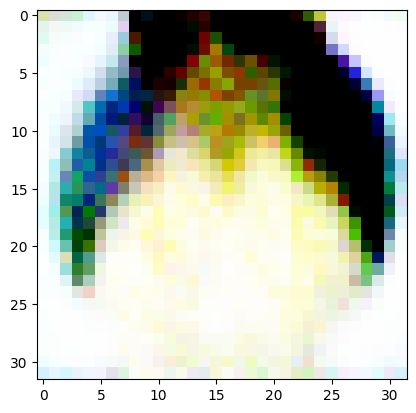

In [50]:
_ = get_generation(
    "./dataset/test/imgs/0b066ffd-cd36-4d65-8e6f-8c4c4c3eaac2.jpg",
    "./model.pth",
    transform,
    model=model,
)
_ = _.view(3, 32, 32).detach().numpy()
_ = _.transpose(1,2,0)
plt.imshow(_)

In [51]:
images_to_check_gen = [
    ["b352245b-0a30-4478-ba46-05d8ca08585b.jpg", 0],
    ["ae858b79-002a-4aa6-9ece-9861bc73dc00.jpg", 1],
    ["063f8ee4-8267-4f2a-bcca-e8857f5e70ed.jpg", 0],
    ["e97a1617-62f5-447f-a0a3-d599441d2b7e.jpg", 1],
    ["07f7e150-84b7-4093-be6a-cd70a8410528.jpg", 0],
    ["06d839ed-2df0-487f-aa5f-43e487211f93.jpg", 1],
]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


normal


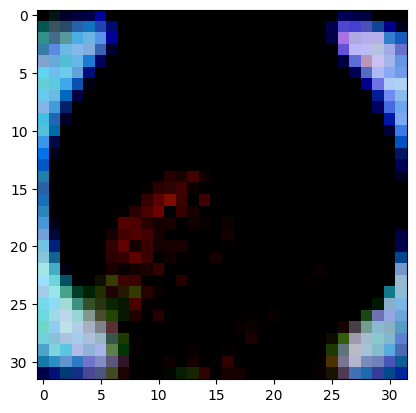

In [52]:
img_path = images_to_check_gen[0][0]
str_tag = "proliv" if images_to_check_gen[0][1] == 1 else "normal"
print(str_tag)
gen_image = (
    get_generation(
        f"./dataset/test/imgs/{img_path}",
        "./model.pth",
        transform,
        model=model,
    )
    .view(3, 32, 32)
    .detach()
    .numpy()
    .transpose(1, 2, 0)
)
plt.imshow(gen_image)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


proliv


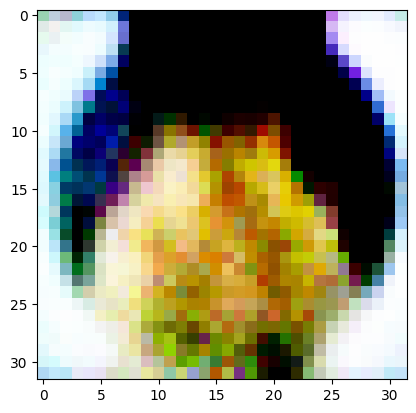

In [53]:
img_path = images_to_check_gen[1][0]
str_tag = "proliv" if images_to_check_gen[1][1] == 1 else "normal"
print(str_tag)
gen_image = (
    get_generation(
        f"./dataset/test/imgs/{img_path}",
        "./model.pth",
        transform,
        model=model,
    )
    .view(3, 32, 32)
    .detach()
    .numpy()
    .transpose(1, 2, 0)
)
plt.imshow(gen_image)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


normal


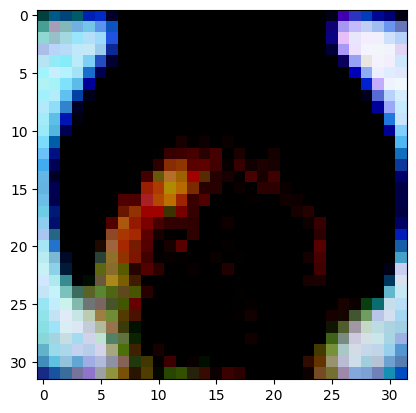

In [54]:
img_path = images_to_check_gen[2][0]
str_tag = "proliv" if images_to_check_gen[2][1] == 1 else "normal"
print(str_tag)
gen_image = (
    get_generation(
        f"./dataset/test/imgs/{img_path}",
        "./model.pth",
        transform,
        model=model,
    )
    .view(3, 32, 32)
    .detach()
    .numpy()
    .transpose(1, 2, 0)
)
plt.imshow(gen_image)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


proliv


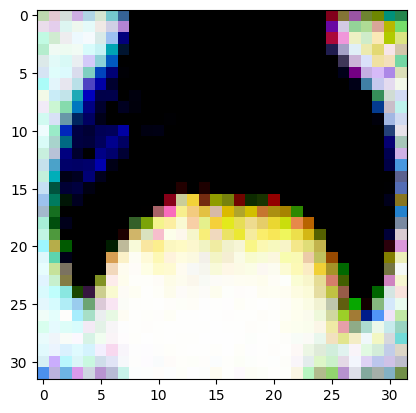

In [55]:
img_path = images_to_check_gen[3][0]
str_tag = "proliv" if images_to_check_gen[3][1] == 1 else "normal"
print(str_tag)
gen_image = (
    get_generation(
        f"./dataset/test/imgs/{img_path}",
        "./model.pth",
        transform,
        model=model,
    )
    .view(3, 32, 32)
    .detach()
    .numpy()
    .transpose(1, 2, 0)
)
plt.imshow(gen_image)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


normal


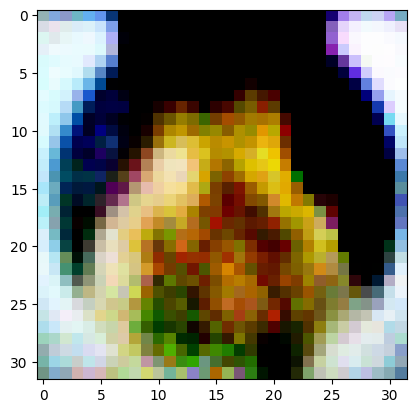

In [56]:
img_path = images_to_check_gen[4][0]
str_tag = "proliv" if images_to_check_gen[4][1] == 1 else "normal"
print(str_tag)
gen_image = (
    get_generation(
        f"./dataset/test/imgs/{img_path}",
        "./model.pth",
        transform,
        model=model,
    )
    .view(3, 32, 32)
    .detach()
    .numpy()
    .transpose(1, 2, 0)
)
plt.imshow(gen_image)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


proliv


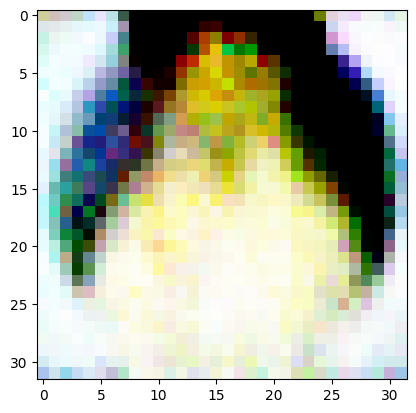

In [57]:
img_path = images_to_check_gen[5][0]
str_tag = "proliv" if images_to_check_gen[5][1] == 1 else "normal"
print(str_tag)
gen_image = (
    get_generation(
        f"./dataset/test/imgs/{img_path}",
        "./model.pth",
        transform,
        model=model,
    )
    .view(3, 32, 32)
    .detach()
    .numpy()
    .transpose(1, 2, 0)
)
plt.imshow(gen_image)